In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import io
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [ ]:
import os

In [ ]:
#read the train.csv file
from google.colab import files
uploaded1 = files.upload()

Saving combined.csv to combined.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded1['combined.csv']))

In [ ]:
df.head(10)

,tweet_id,tweet_time,tweet_author,tweet_author_id,tweet_language,tweet_lon,tweet_lat,tweet_text,tweet_url,label
0,451280656090157056',Wed Apr 02 08:51:07 +0000 2014,latinpr_Au,1574771142,en,NaN,NaN,Let's all keep Chile and our friends in our th...,https://twitter.com/latinpr_Au/status/45128065...,Earthquake
1,451281454429769728',Wed Apr 02 08:54:17 +0000 2014,articulas77,161667670,en,NaN,NaN,Residents flee 8.2 magnitude earthquake strike...,https://twitter.com/articulas77/status/4512814...,Earthquake
2,451281747703902208',Wed Apr 02 08:55:27 +0000 2014,nicoledpnd,184651091,en,NaN,NaN,Our thoughts are with you. #PrayForChile �__F,https://twitter.com/nicoledpnd/status/45128174...,Earthquake
3,451281792809439233',Wed Apr 02 08:55:38 +0000 2014,MARLONGILLDEVAU,21970908,en,NaN,NaN,Powerful 8.2-magnitude earthquake off Chile ki...,https://twitter.com/MARLONGILLDEVAU/status/451...,Earthquake
4,451281861029793792',Wed Apr 02 08:55:54 +0000 2014,saiful_haq,90202028,en,NaN,NaN,pray for Chile.. #tsunami,https://twitter.com/saiful_haq/status/45128186...,Earthquake
5,451281935130583040',Wed Apr 02 08:56:12 +0000 2014,nowghana,479022962,en,NaN,NaN,"Tsunami-triggering earthquake strikes Chile,ki...",https://twitter.com/nowghana/status/4512819351...,Earthquake
6,451282059923693569',Wed Apr 02 08:56:42 +0000 2014,aniesvarani,70090338,en,NaN,NaN,"8,2 SR earthquake and tsunami #prayforChile",https://twitter.com/aniesvarani/status/4512820...,Earthquake
7,451282106111766529',Wed Apr 02 08:56:53 +0000 2014,ftweeknd,1765054699,en,NaN,NaN,#PrayForChile stay safe,https://twitter.com/ftweeknd/status/4512821061...,Earthquake
8,451283095946547200',Wed Apr 02 09:00:49 +0000 2014,NBCNewsWorld,11855772,en,NaN,NaN,Chile Earthquake: Deadly Magnitude-8.2 Temblor...,https://twitter.com/NBCNewsWorld/status/451283...,Earthquake
9,451283243749224449',Wed Apr 02 09:01:24 +0000 2014,chikaviiero,357996285,en,NaN,NaN,"Magnitude 8.3 earthquake, causing 5 person's d...",https://twitter.com/chikaviiero/status/4512832...,Earthquake


In [ ]:
print('There are {} rows and {} columns in train'.format(df.shape[0],df.shape[1]))

There are 1710 rows and 10 columns in train


Text(0, 0.5, 'samples')

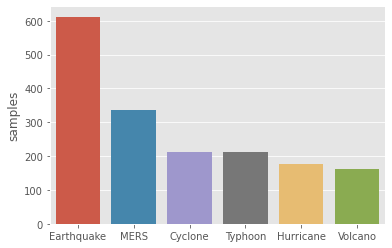

In [ ]:
#check class distribution in trainset 
x=df.label.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

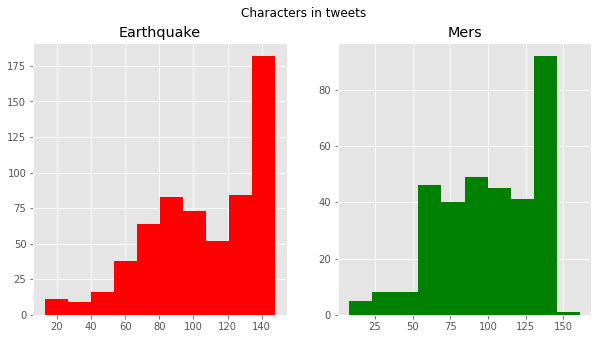

In [ ]:
#number of characters in tweets 
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
tweet_len = df[df['label']=="Earthquake"]['tweet_text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Earthquake')
tweet_len=df[df['label']=="MERS"]['tweet_text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Mers')
fig.suptitle('Characters in tweets')
plt.show()

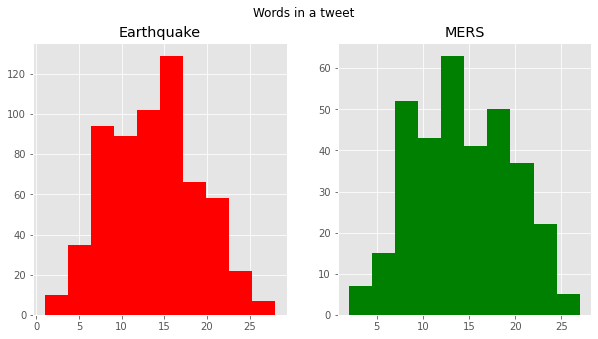

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df[df['label']=="Earthquake"]['tweet_text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('Earthquake')
tweet_len=df[df['label']=="MERS"]['tweet_text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('MERS')
fig.suptitle('Words in a tweet')
plt.show()

Text(0.5, 0.98, 'Average word length in each tweet')

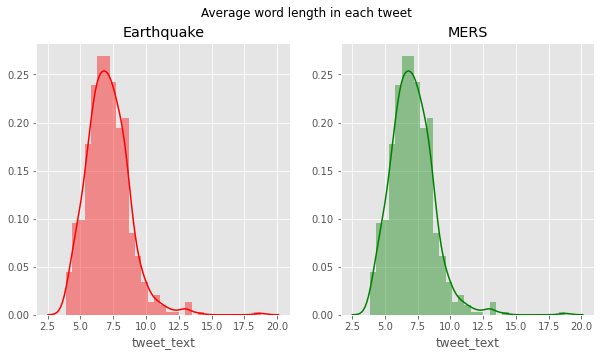

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=df[df['label']=="Earthquake"]['tweet_text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Earthquake')
word=df[df['label']=="Earthquake"]['tweet_text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('MERS')
fig.suptitle('Average word length in each tweet')

In [ ]:
#create corpus according to target number
def create_corpus(label):
    corpus=[]
    
    for x in train[train['label']==label]['tweet_text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
#we start with tweets from class 1 (Earthquake)
corpus=create_corpus("Earthquake")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

<BarContainer object of 10 artists>

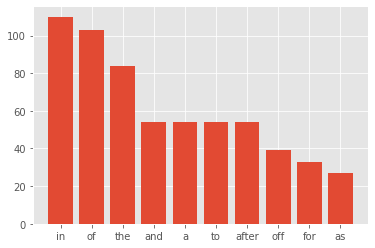

In [ ]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 12 artists>

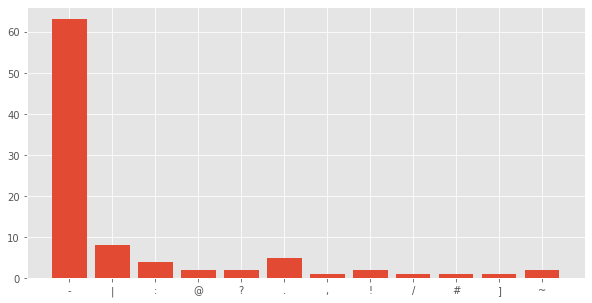

In [ ]:
#Now we analyze punctuations for class 1
plt.figure(figsize=(10,5))
corpus=create_corpus("Earthquake")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 6 artists>

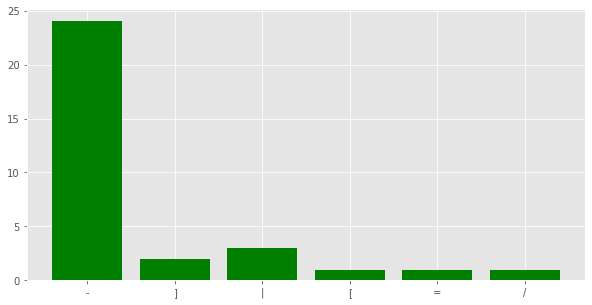

In [ ]:
#Now we analyze punctuations for class 1
plt.figure(figsize=(10,5))
corpus=create_corpus("Hurricane")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='green')

In [ ]:
#most common words not int stop, for class MERS
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

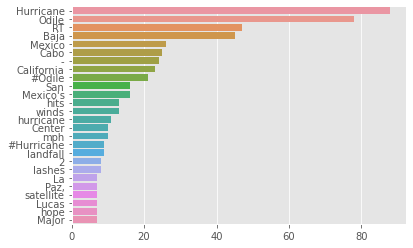

In [ ]:
sns.barplot(x=y,y=x)

In [ ]:
#Removing urls
example="New competition launched :https://www.google.com"
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [ ]:
df['tweet_text']=df['tweet_text'].apply(lambda x : remove_URL(x))

In [ ]:
#Remove the html tags 
example = """<div>
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

In [ ]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
print(remove_html(example))


Real or Fake
Kaggle 
getting started



In [ ]:
df['tweet_text']=df['tweet_text'].apply(lambda x : remove_html(x))

In [ ]:
#remove emojis
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("OMG another Earthquake 😔😔")

'OMG another Earthquake '

In [ ]:
df['tweet_text']=df['tweet_text'].apply(lambda x: remove_emoji(x))

In [ ]:
def remove_punct(text):
  table=str.maketrans('','',string.punctuation)
  return text.translate(table)

example = '#I am a king.'
print(remove_punct(example))

I am a king


In [ ]:
df['tweet_text']=df['tweet_text'].apply(lambda x : remove_punct(x))

In [ ]:
#Now we do some spelling correction 
!pip install pyspellchecker

     |████████████████████████████████| 1.9MB 2.9MB/s 


In [ ]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spellings(text):
  corrected_text=[]
  misspelled_words=spell.unknown(text.split())
  for word in text.split():
    if word in misspelled_words: 
      corrected_text.append(spell.correction(word))
    else:
      corrected_text.append(word)
  return " ".join(corrected_text)

text = "corect me plese"
correct_spellings(text)

'correct me please'

In [ ]:
df['tweet_text']=df['tweet_text'].apply(lambda x : correct_spellings(x))

In [ ]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def tokenize_stem(text):
    
    token_words = word_tokenize(text)
    stem_words =[]
    for i in token_words:
        word = lemmatizer.lemmatize(i)
        stem_words.append(word)
        
    final_tweet = ' '.join(stem_words)
    
    return final_tweet

In [ ]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> wordnet
      Unzipping corpora/wordnet.zip.

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:
from nltk.corpus import wordnet as wn

In [ ]:
df['tweet_text'] = df['tweet_text'].apply(lambda x: tokenize_stem(x))


In [ ]:
from io import StringIO
col = ['label', 'tweet_text']
df = df[col]
df = df[pd.notnull(df['tweet_text'])]
df.columns = ['label', 'tweet_text']
df['category_id'] = df['label'].factorize()[0]
category_id_df = df[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)
df.head(500)

,label,tweet_text,category_id
0,Earthquake,Lets all keep Chile and our friend in our thou...,0
1,Earthquake,Residents flee 82 magnitude earthquake strike ...,0
2,Earthquake,Our thought are with you PrayForChile F,0
3,Earthquake,Powerful 82magnitude earthquake off Chile kill...,0
4,Earthquake,pray for Chile tsunami,0
...,...,...,...
495,Cyclone,Help the victimes of CyclonePAM Its hitting So...,1
496,Cyclone,VIDEO Cyclone Pam My hotel is shaking,1
497,Cyclone,Vanuatu RT Cyclone threatens Vanuatu two Austr...,1
498,Cyclone,Sending light to all in Vanuatu in the wake of...,1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.tweet_text).toarray()
labels = df.category_id
features.shape

(1710, 1685)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for label, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(label))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Cyclone':
  . Most correlated unigrams:
. vanuatu
. cyclone
  . Most correlated bigrams:
. tropical cyclone
. cyclone pam
# 'Earthquake':
  . Most correlated unigrams:
. earthquake
. chile
  . Most correlated bigrams:
. northern chile
. chile earthquake
# 'Hurricane':
  . Most correlated unigrams:
. hurricane
. odile
  . Most correlated bigrams:
. baja california
. hurricane odile
# 'MERS':
  . Most correlated unigrams:
. virus
. mers
  . Most correlated bigrams:
. saudi arabia
. mers virus
# 'Typhoon':
  . Most correlated unigrams:
. hagupit
. typhoon
  . Most correlated bigrams:
. hagupit evacuation
. typhoon hagupit
# 'Volcano':
  . Most correlated unigrams:
. iceland
. volcano
  . Most correlated bigrams:
. bardarbunga volcano
. iceland volcano


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['tweet_text'], df['label'], random_state = 0,test_size=0.33 )
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = count_vect.transform(X_test)
clf = MultinomialNB().fit(X_train_tfidf, y_train)
model = LinearSVC().fit(X_train_tfidf, y_train)

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score

pred_naive = clf.predict(X_test_tfidf)
pred_svm = model.predict(X_test_tfidf)


F1 Score : 0.945
recall Score : 0.945
precision Score : 0.945


In [ ]:
f1score = f1_score(y_test,pred_naive, average='micro')
recall = recall_score(y_test, pred_naive, average='micro')
precision = precision_score(y_test, pred_naive, average='micro')
print('F1 Score : %.3f' %(f1score))
print('recall Score : %.3f' %(recall))
print('precision Score : %.3f' %(precision))

F1 Score : 0.945
recall Score : 0.945
precision Score : 0.945


In [ ]:
f1score = f1_score(y_test,pred_svm, average='micro')
recall = recall_score(y_test, pred_svm, average='micro')
precision = precision_score(y_test, pred_svm, average='micro')
print('F1 Score : %.3f' %(f1score))
print('recall Score : %.3f' %(recall))
print('precision Score : %.3f' %(precision))

F1 Score : 0.988
recall Score : 0.988
precision Score : 0.988


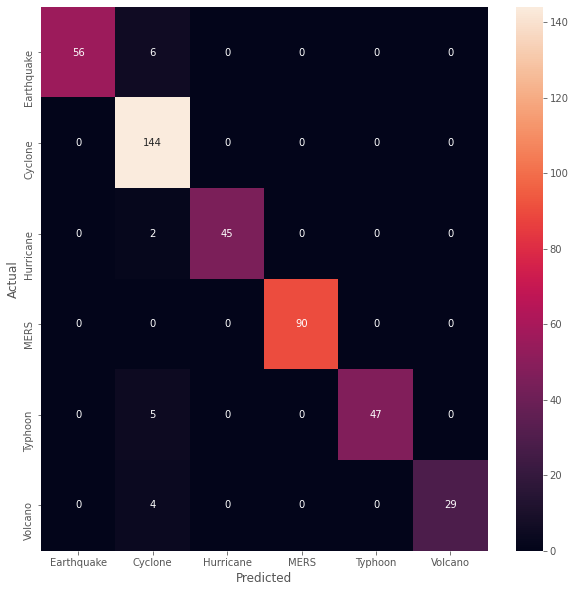

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, pred_naive)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

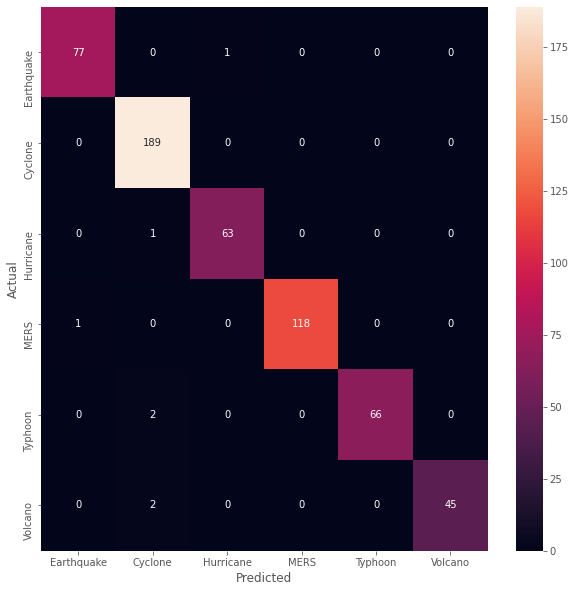

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, pred_svm)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(clf.predict(count_vect.transform(["hundreds of houses were destroyed due to a magnitude of 30 degrees"])))

['Earthquake']


In [ ]:
print(clf.predict(count_vect.transform(["Many cases of the virus were discovered"])))

['MERS']


In [ ]:
print(clf.predict(count_vect.transform(["Intense activity at Nishinoshima volcano, summit crater extends as explosive eruptions continue, Japan"])))

['Volcano']


In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['label'].unique()))


              precision    recall  f1-score   support

  Earthquake       0.97      1.00      0.99       189
     Cyclone       0.99      0.97      0.98        78
   Hurricane       1.00      0.98      0.99        64
        MERS       1.00      0.99      1.00       119
     Typhoon       0.99      0.97      0.98        68
     Volcano       1.00      0.98      0.99        47

    accuracy                           0.99       565
   macro avg       0.99      0.98      0.99       565
weighted avg       0.99      0.99      0.99       565

